In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
val_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

In [4]:
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
val_dataset = datasets.STL10(root='./data', split='test', download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [6]:
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
print(imgs.size())

torch.Size([128, 3, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


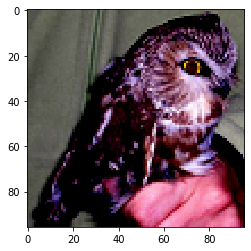

In [7]:
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
plt.imshow(imgs[0].permute(1,2,0))

In [11]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [12]:
for param in model.parameters():
    param.requires_grad=False

In [14]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [15]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
%%time
num_epochs = 15
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    model.train()

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        train_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)
        train_acc += (pred == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
          
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            pred = torch.argmax(outputs, dim=1)
            val_acc += (pred == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)
        
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/15], Loss: 0.0135, val_loss: 0.0087, val_acc: 0.6653
Epoch [2/15], Loss: 0.0086, val_loss: 0.0069, val_acc: 0.7276
Epoch [3/15], Loss: 0.0076, val_loss: 0.0064, val_acc: 0.7380
Epoch [4/15], Loss: 0.0069, val_loss: 0.0062, val_acc: 0.7468
Epoch [5/15], Loss: 0.0067, val_loss: 0.0059, val_acc: 0.7570
Epoch [6/15], Loss: 0.0063, val_loss: 0.0057, val_acc: 0.7649
Epoch [7/15], Loss: 0.0060, val_loss: 0.0057, val_acc: 0.7619
Epoch [8/15], Loss: 0.0060, val_loss: 0.0057, val_acc: 0.7595
Epoch [9/15], Loss: 0.0060, val_loss: 0.0056, val_acc: 0.7605
Epoch [10/15], Loss: 0.0057, val_loss: 0.0054, val_acc: 0.7700
Epoch [11/15], Loss: 0.0057, val_loss: 0.0054, val_acc: 0.7688


In [ ]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

In [ ]:
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()